# Book Orders Data Analysis

This notebook analyzes book order data from three different data folders (DATA1, DATA2, DATA3).

## Tasks:
1. Load and clean data from each folder
2. Compute daily revenue and find top 5 days
3. Find unique users (reconciling aliases/changed fields)
4. Find unique author sets
5. Find most popular author(s)
6. Identify top customer by spending
7. Plot daily revenue charts

## 1. Import Required Libraries

In [ ]:
import json
import re
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from dateutil import parser as date_parser

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

BASE_PATH = Path('data')
DATA_FOLDERS = ['DATA1', 'DATA2', 'DATA3']
EUR_TO_USD_RATE = 1.2

print("✅ Setup complete")

✅ Setup complete


## 2. Data Loading Functions

In [ ]:
def load_users(folder_path: Path) -> pd.DataFrame:
    """Load and clean users data from CSV file."""
    df = pd.read_csv(folder_path / 'users.csv')
    df = df.replace(['NULL', ' ', ''], np.nan)
    
    for col in ['name', 'address', 'phone', 'email']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip().replace('nan', np.nan)
    
    return df.drop_duplicates()


def load_books(folder_path: Path) -> pd.DataFrame:
    """Load and clean books data from YAML file."""
    with open(folder_path / 'books.yaml', 'r') as f:
        data = yaml.safe_load(f)
    
    df = pd.DataFrame(data)
    df.columns = [col.lstrip(':') for col in df.columns]  # Remove Ruby symbols
    df['publisher'] = df['publisher'].replace(' ', np.nan)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df.columns = [col.lstrip(':') for col in df.columns]
    return df.drop_duplicates()


def parse_price(price_str) -> float:
    """
    Parse price from various formats and convert to USD.
    
    Supported formats: '27.00$', '€50¢50', 'USD 45.99', '€ 71.00', '52.25 $', '22$75¢'
    """
    if pd.isna(price_str):
        return np.nan
    
    price_str = str(price_str).strip()
    is_euro = '€' in price_str or 'EUR' in price_str.upper()
    
    # Handle cents format (e.g., '22$75¢', '€50¢50')
    if '¢' in price_str:
        parts = [p.strip() for p in re.split(r'[\$€¢]', price_str) if p.strip()]
    if '¢' in price_str:
        parts = [p.strip() for p in re.split(r'[\$€¢]', price_str) if p.strip()]
        main_value = float(parts[0]) if parts else 0
        cents_value = float(parts[1]) if len(parts) > 1 else 0
        value = main_value + cents_value / 100
    else:
        cleaned = re.sub(r'[€$]|USD|EUR', '', price_str).strip()
        value = float(cleaned) if cleaned else 0
    
    return round(value * EUR_TO_USD_RATE if is_euro else value, 2)


def parse_timestamp(ts_str):
    """Parse timestamp from various formats using fuzzy parsing."""
    if pd.isna(ts_str):
        return pd.NaT
    
    ts_clean = str(ts_str).strip()
    ts_clean = re.sub(r'[AP]\.M\.', lambda m: m.group().replace('.', ''), ts_clean, flags=re.I)
    ts_clean = ts_clean.replace(';', ' ').replace(',', ' ')
    
    try:
        return date_parser.parse(ts_clean, fuzzy=True)
    except (ValueError, TypeError):
        return pd.NaT


def load_orders(folder_path: Path) -> pd.DataFrame:
    """Load and process orders data from Parquet file."""
    df = pd.read_parquet(folder_path / 'orders.parquet')
    
    # Parse price and timestamp (apply is needed for complex parsing logic)
    df['unit_price_usd'] = df['unit_price'].apply(parse_price)
    df['unit_price_usd'] = df['unit_price'].apply(parse_price)
    df['timestamp_parsed'] = df['timestamp'].apply(parse_timestamp)
    df['timestamp_parsed'] = pd.to_datetime(df['timestamp_parsed'], errors='coerce')
    
    df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')
    df['paid_price'] = (df['quantity'] * df['unit_price_usd']).round(2)
    df['date'] = df['timestamp_parsed'].dt.date
    
    return df.drop_duplicates()


def load_dataset(folder_name: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load all data for a dataset folder."""
    folder_path = BASE_PATH / folder_name
    return load_users(folder_path), load_books(folder_path), load_orders(folder_path)


✅ Data loading functions defined


In [ ]:
class UnionFind:
    """Union-Find data structure with path compression and union by rank."""
    
    def __init__(self, n: int):
        self.parent = list(range(n))
        self.rank = [0] * n
    
    def find(self, x: int) -> int:
        """Iterative find with path compression (avoids recursion limit)."""
        root = x
        while self.parent[root] != root:
            root = self.parent[root]
        # Path compression
        while self.parent[x] != root:
            next_x = self.parent[x]
            self.parent[x] = root
            x = next_x
        return root
    
    def union(self, x: int, y: int) -> None:
        px, py = self.find(x), self.find(y)
        if px == py:
            return
        if self.rank[px] < self.rank[py]:
            px, py = py, px
        self.parent[py] = px
        if self.rank[px] == self.rank[py]:
            self.rank[px] += 1
    
    def get_groups(self) -> dict[int, list[int]]:
        groups = defaultdict(list)
        for i in range(len(self.parent)):
            groups[self.find(i)].append(i)
        return dict(groups)


def normalize_phone(phone) -> str | None:
    """Extract digits from phone number for comparison."""
    if pd.isna(phone) or phone == 'nan':
        return None
    return ''.join(filter(str.isdigit, str(phone)))


def reconcile_users(users_df: pd.DataFrame) -> tuple[int, dict]:
    """
    Reconcile users who are the same person with different fields.
    
    Uses hash-based grouping O(n) - groups users sharing same email or phone.
    
    Returns: (unique_count, user_groups_dict)
    """
    df = users_df.copy().reset_index(drop=True)
    df['phone_norm'] = df['phone'].apply(normalize_phone)
    df['email_norm'] = df['email'].str.lower().str.strip()
    
    n = len(df)
    uf = UnionFind(n)
    
    for indices in df[df['email_norm'].notna()].groupby('email_norm').indices.values():
        if len(indices) > 1:
            first = indices[0]
            for idx in indices[1:]:
                uf.union(first, idx)
    
    for indices in df[df['phone_norm'].notna()].groupby('phone_norm').indices.values():
        if len(indices) > 1:
            first = indices[0]
            for idx in indices[1:]:
                uf.union(first, idx)
    
    groups = uf.get_groups()
    ids = df['id'].values
    user_groups = {root: [ids[i] for i in indices] for root, indices in groups.items()}
    
    return len(user_groups), user_groups


def find_unique_author_sets(books_df: pd.DataFrame) -> int:
    """Count unique author combinations (handles co-authored books)."""
    author_sets = {
        tuple(sorted(a.strip() for a in str(author).split(',')))
        for author in books_df['author'].dropna()
    }
    return len(author_sets)


def find_most_popular_author(orders_df: pd.DataFrame, books_df: pd.DataFrame) -> tuple[list[str], int]:
    """
    Find individual author(s) with most books sold (handles ties).
    
    Properly handles co-authored books by exploding author lists,
    crediting each individual author for their contribution.
    """
    merged = orders_df.merge(books_df[['id', 'author']], left_on='book_id', right_on='id', how='left')
    
    # Explode co-authored books to credit each individual author
    merged['author_list'] = merged['author'].astype(str).str.split(',')
    exploded = merged.explode('author_list')
    merged['author_list'] = merged['author'].astype(str).str.split(',')
    exploded = merged.explode('author_list')
    exploded['author_list'] = exploded['author_list'].str.strip()
    
    sales = exploded.groupby('author_list')['quantity'].sum()
    max_sold = sales.max()
    
    return sales[sales == max_sold].index.tolist(), int(max_sold)


def find_top_customer(orders_df: pd.DataFrame, user_groups: dict) -> tuple[list[int], float]:
    """Find customer group with highest total spending."""
    # Build user_id -> group_id mapping
    user_to_group = {uid: gid for gid, uids in enumerate(user_groups.values()) for uid in uids}
    user_to_group = {uid: gid for gid, uids in enumerate(user_groups.values()) for uid in uids}
    
    spending = orders_df.groupby('user_id')['paid_price'].sum().reset_index()
    spending['group'] = spending['user_id'].map(user_to_group)
    group_totals = spending.groupby('group')['paid_price'].sum()
    
    top_group = group_totals.idxmax()
    top_user_ids = sorted(spending[spending['group'] == top_group]['user_id'].tolist())
    
    return top_user_ids, group_totals.max()


def compute_daily_revenue(orders_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Compute daily revenue and find top 5 days."""
    valid = orders_df.dropna(subset=['date', 'paid_price'])
    daily = valid.groupby('date')['paid_price'].sum().reset_index()
    daily.columns = ['date', 'revenue']
    daily = daily.sort_values('date')
    
    top_5 = daily.nlargest(5, 'revenue').copy()
    top_5['date'] = pd.to_datetime(top_5['date']).dt.strftime('%Y-%m-%d')
    
    return daily, top_5


def export_to_json(results: dict, output_path: str = 'dashboard_data.json') -> None:
    """Export analysis results to JSON for dashboard consumption."""
    dashboard_data = {}
    
    for folder, result in results.items():
        daily_rev = result['daily_revenue'].copy()
        daily_rev['date'] = pd.to_datetime(daily_rev['date']).dt.strftime('%Y-%m-%d')
        
        dashboard_data[folder] = {
            'top_5_days': result['top_5_days'],
            'top_5_revenue': [round(r, 2) for r in result['top_5_revenue']],
            'unique_users': result['unique_users'],
            'unique_author_sets': result['unique_author_sets'],
            'most_popular_author': result['most_popular_author'],
            'top_customer_ids': [int(x) for x in result['top_customer_ids']],
            'top_customer_spending': round(result['top_customer_spending'], 2),
            'daily_revenue': {
                'dates': daily_rev['date'].tolist(),
                'values': [round(v, 2) for v in daily_rev['revenue'].tolist()]
            }
        }
    
    with open(output_path, 'w') as f:
        json.dump(dashboard_data, f, indent=2)
    
    print(f"✅ Exported to {output_path}")


✅ Analysis functions defined


In [ ]:
def plot_daily_revenue(daily_revenue: pd.DataFrame, title: str = "Daily Revenue") -> None:
    """Create and display daily revenue line chart with area fill."""
    fig, ax = plt.subplots(figsize=(14, 6))
    dates = pd.to_datetime(daily_revenue['date'])
    
    ax.plot(dates, daily_revenue['revenue'], linewidth=2, color='#2E86AB', marker='o', markersize=2)
    ax.fill_between(dates, daily_revenue['revenue'], alpha=0.3, color='#2E86AB')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Revenue ($)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def analyze_dataset(folder_name: str) -> dict:
    """
    Perform complete analysis for a dataset folder.
    
    Returns dict with all metrics for dashboard export.
    """
    print(f"\n{'='*60}\n📊 ANALYZING {folder_name}\n{'='*60}")
    
    users_df, books_df, orders_df = load_dataset(folder_name)
    print(f"📁 Loaded: {len(users_df)} users, {len(books_df)} books, {len(orders_df)} orders")
    
    daily_revenue, top_5_days = compute_daily_revenue(orders_df)
    unique_users, user_groups = reconcile_users(users_df)
    unique_author_sets = find_unique_author_sets(books_df)
    popular_authors, books_sold = find_most_popular_author(orders_df, books_df)
    top_customer_ids, top_spending = find_top_customer(orders_df, user_groups)
    
    print(f"\n🏆 Top 5 Days: {top_5_days['date'].tolist()}")
    print(f"👥 Unique Users: {unique_users}")
    print(f"📚 Author Sets: {unique_author_sets}")
    print(f"⭐ Popular Author: {popular_authors[0]} ({books_sold} sold)")
    print(f"💰 Top Customer: {top_customer_ids} (${top_spending:,.2f})")
    
    # Plot
    plot_daily_revenue(daily_revenue, f"Daily Revenue - {folder_name}")
    
    plot_daily_revenue(daily_revenue, f"Daily Revenue - {folder_name}")
    
    return {
        'folder': folder_name,
        'top_5_days': top_5_days['date'].tolist(),
        'top_5_revenue': top_5_days['revenue'].tolist(),
        'unique_users': unique_users,
        'unique_author_sets': unique_author_sets,
        'most_popular_author': popular_authors,
        'top_customer_ids': top_customer_ids,
        'top_customer_spending': top_spending,
        'daily_revenue': daily_revenue,
    }

✅ Main analysis function defined


## 3. Run Analysis for All Datasets


📊 ANALYZING DATA1
📁 Loaded: 3293 users, 753 books, 11237 orders

🏆 Top 5 Days: ['2025-01-02', '2024-11-14', '2024-09-06', '2024-11-09', '2024-10-07']
👥 Unique Users: 3115
📚 Author Sets: 325
⭐ Popular Author: Maynard Bartoletti Ret. (275 sold)
💰 Top Customer: [44850, 45062, 46955] ($1,386.76)
📁 Loaded: 3293 users, 753 books, 11237 orders

🏆 Top 5 Days: ['2025-01-02', '2024-11-14', '2024-09-06', '2024-11-09', '2024-10-07']
👥 Unique Users: 3115
📚 Author Sets: 325
⭐ Popular Author: Maynard Bartoletti Ret. (275 sold)
💰 Top Customer: [44850, 45062, 46955] ($1,386.76)


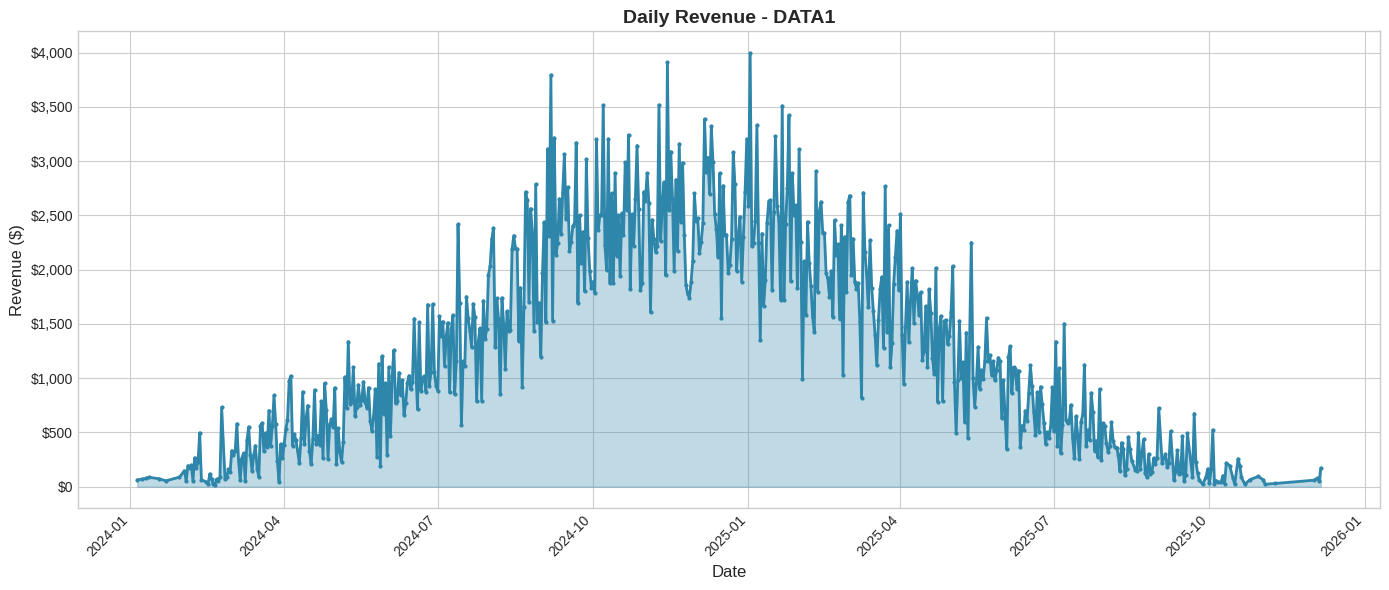


📊 ANALYZING DATA2
📁 Loaded: 2810 users, 741 books, 9850 orders

🏆 Top 5 Days: ['2024-09-12', '2024-11-15', '2024-11-21', '2024-12-25', '2025-01-20']
👥 Unique Users: 2663
📚 Author Sets: 293
⭐ Popular Author: Hershel Treutel (225 sold)
💰 Top Customer: [53583, 55058, 55420] ($1,312.84)
📁 Loaded: 2810 users, 741 books, 9850 orders

🏆 Top 5 Days: ['2024-09-12', '2024-11-15', '2024-11-21', '2024-12-25', '2025-01-20']
👥 Unique Users: 2663
📚 Author Sets: 293
⭐ Popular Author: Hershel Treutel (225 sold)
💰 Top Customer: [53583, 55058, 55420] ($1,312.84)


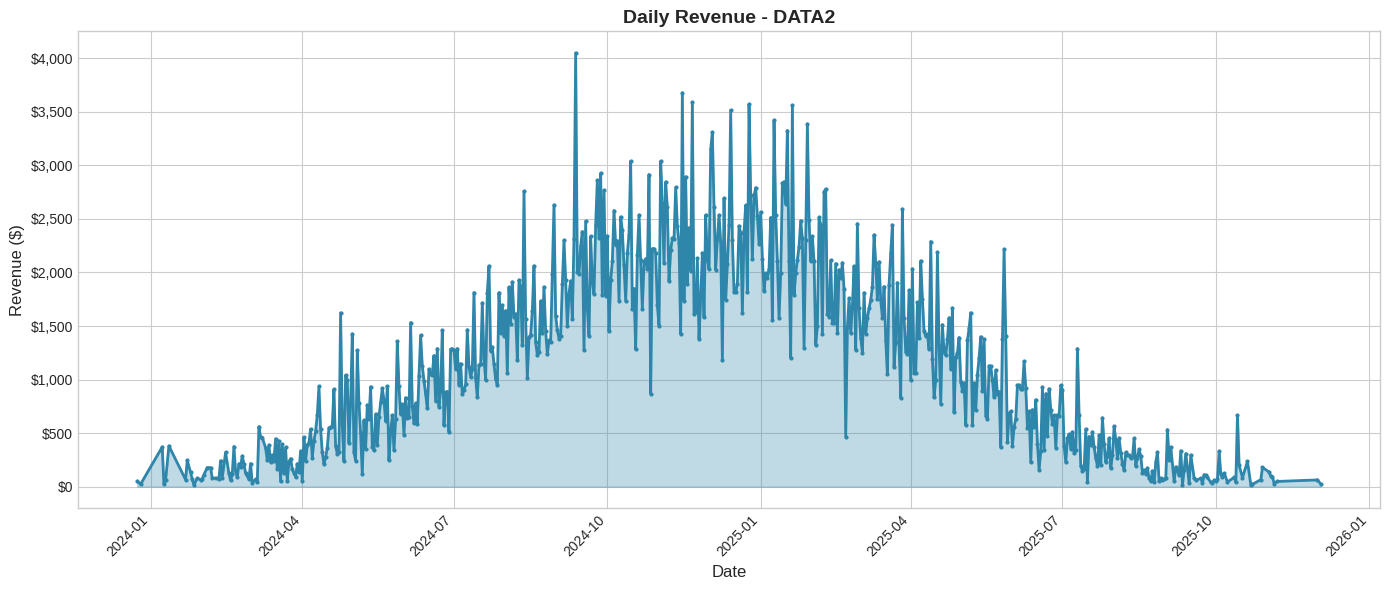


📊 ANALYZING DATA3
📁 Loaded: 3466 users, 762 books, 8933 orders

🏆 Top 5 Days: ['2024-11-16', '2025-01-31', '2024-10-26', '2024-11-12', '2024-11-01']
👥 Unique Users: 3290
📚 Author Sets: 268
⭐ Popular Author: Era Hodkiewicz (236 sold)
💰 Top Customer: [49715, 50963] ($1,207.48)
📁 Loaded: 3466 users, 762 books, 8933 orders

🏆 Top 5 Days: ['2024-11-16', '2025-01-31', '2024-10-26', '2024-11-12', '2024-11-01']
👥 Unique Users: 3290
📚 Author Sets: 268
⭐ Popular Author: Era Hodkiewicz (236 sold)
💰 Top Customer: [49715, 50963] ($1,207.48)


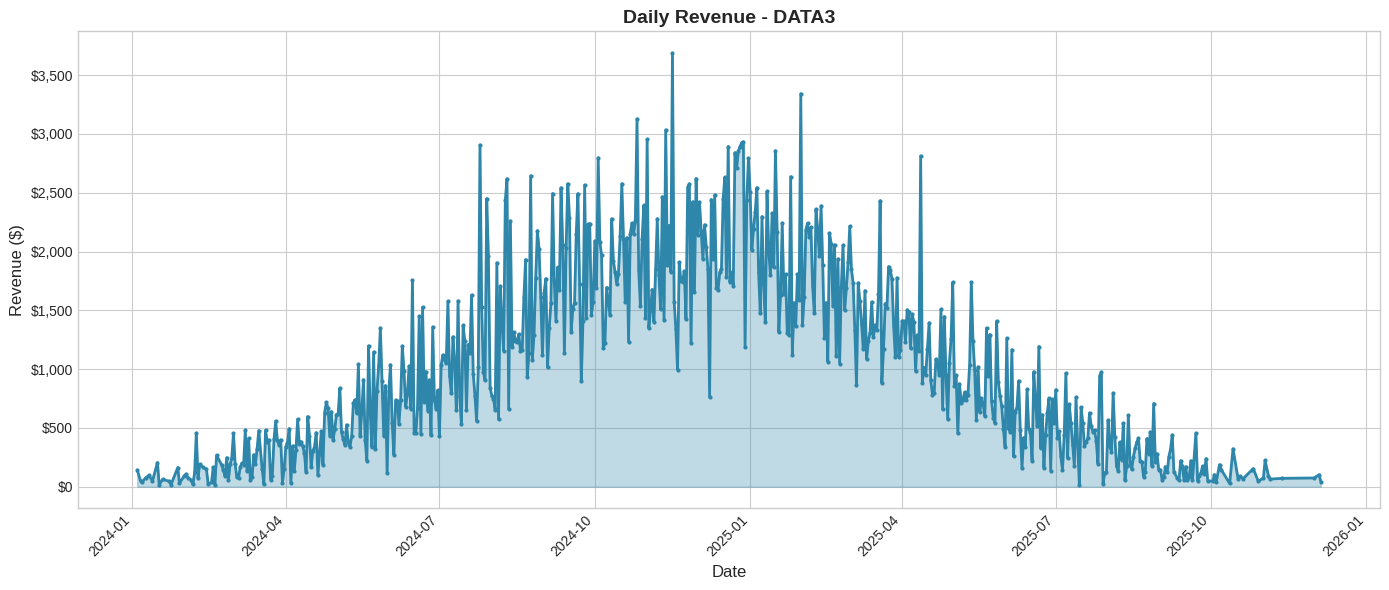

In [ ]:
results = {folder: analyze_dataset(folder) for folder in DATA_FOLDERS}

## 4. Summary

In [ ]:
summary_data = []
for folder, result in results.items():
    summary_data.append({
        'Dataset': folder,
        'Top Day': result['top_5_days'][0],
        'Unique Users': result['unique_users'],
        'Author Sets': result['unique_author_sets'],
        'Popular Author': result['most_popular_author'][0],
        'Top Customer IDs': result['top_customer_ids'],
        'Top Spending': f"${result['top_customer_spending']:,.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n📊 ANALYSIS SUMMARY\n")
print(summary_df.to_string(index=False))


📊 ANALYSIS SUMMARY

Dataset    Top Day  Unique Users  Author Sets          Popular Author      Top Customer IDs Top Spending
  DATA1 2025-01-02          3115          325 Maynard Bartoletti Ret. [44850, 45062, 46955]    $1,386.76
  DATA2 2024-09-12          2663          293         Hershel Treutel [53583, 55058, 55420]    $1,312.84
  DATA3 2024-11-16          3290          268          Era Hodkiewicz        [49715, 50963]    $1,207.48


## 5. Export to Dashboard

In [48]:
export_to_json(results, 'docs/dashboard_data.json')

✅ Exported to docs/dashboard_data.json
